In [129]:
# https://github.com/clovaai/deep-text-recognition-benchmark#download-lmdb-dataset-for-traininig-and-evaluation-from-here
# https://github.com/clovaai/CRAFT-pytorch
# https://pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/ Non maximum suppression

In [ ]:
# TODO rifinire singole bounding boxes: capire se sono ruotate e raddrizzarle per eccesso per facilitare l'ocr?

In [1]:
import json
import os
import numpy as np
import urllib.parse
from PIL import Image
import cv2
import types
from collections import namedtuple
import shutil

In [2]:
cwd=os.getcwd()


### paths

In [3]:
import os

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.abspath(os.path.join(root, name)))
    return r

In [4]:
orig_imgs_paths=list_files(f'{cwd}/test_images/post_imgs/TEST/')

In [5]:
orig_imgs_paths

['/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/Ca-GHMas63y.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/CezOjxXOalw_1.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/Cb8fMmqFr6u.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/bboxes_infos.json',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/CcOnQYnOcmB.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/CezOjxXOalw_4.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/Cb_FuDsFwyJ_0.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/CY9MkcNOuHg.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/CH_JQugBNjc_2.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_images/post_imgs/TEST/Cb_FuDsFwyJ_2.jpg',
 '/home/atogni/Desktop/ocr_gradient/craft_model/test_image

In [6]:
try:
    os.mkdir(f'{cwd}/output')
except:
    pass

try:
    os.mkdir(f'{cwd}/output/processed_images')
except:
    pass

processed_images_folder=f'{cwd}/output/processed_images/'
bboxes_path = f"{processed_images_folder}bboxes_infos.json"

In [7]:
for p in orig_imgs_paths:
    shutil.copyfile(p, f"{cwd}/output/processed_images/{p.split('/')[-1]}")
with open(bboxes_path) as f:
    boxes_data_raw=json.load(f)

In [8]:
_IMAGE=orig_imgs_paths[8]

In [9]:
Image.open(_IMAGE)
orig_img=Image.open(_IMAGE)
width, height= orig_img.size

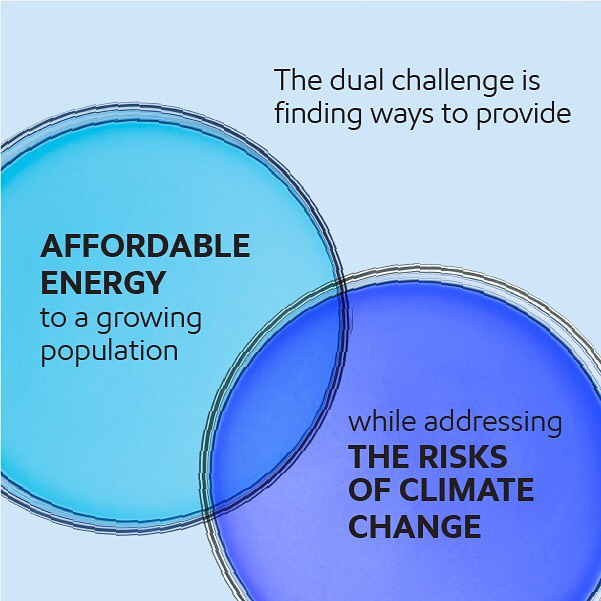

In [10]:
Image.open(_IMAGE)

In [17]:
def show_cv_to_pil(cv_img):
        "Auxiliary function to fix opencv.show() not working on linux"
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(cv_img)
        im_pil.show()
        
import tempfile
import itertools as IT
import os

def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path


In [73]:
from sklearn.cluster import MeanShift
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Any

class BoxesEngine():
    
    @classmethod
    def make_b_list(self, boxes_data_raw, processed_image_path ):
        Idx_Box=namedtuple("Idx_Box", "id top_left bottom_right dx dy")
        tldr_boxes={}
        n=0
        for k, v in boxes_data_raw.items():
            tldr_boxes[k]=[self.xy_box_to_tl_br(box_vertices=box) for box in v]

        for k, v in tldr_boxes.items():
            for i in range(len(v)):
                v[i]=Idx_Box(i, *v[i])
        return tldr_boxes[processed_image_path.split('/')[-1]], tldr_boxes
    
    @classmethod
    def extract_area_of_4boxes_list(self, list_bboxes):
        "Extract area of a list of boxes in 4 vertex format"
        a=0.0
        for box in list_bboxes:
            dx=round(max(box[0][0], box[1][0]) - min(box[0][0], box[1][0]), 2)
            dy=round(max(box[0][1], box[3][1]) - min(box[0][1], box[3][1]), 2)
            a+=dx*dy
        return round(a, 0)
    
    @classmethod
    def extract_area_of_tl_br_box_list(self,tl_br_tup_lst):
        "Calculate area of a tl_dr box list"
        a=0.0
        for tl_br_tup in tl_br_tup_lst:
            dx=round(max(tl_br_tup[0][0], tl_br_tup[1][0]) - min(tl_br_tup[0][0], tl_br_tup[1][0]), 0)
            dy=round(max(tl_br_tup[0][1], tl_br_tup[1][1]) - min(tl_br_tup[0][1], tl_br_tup[1][1]), 0)
            a+= int(dx*dy)
        return a
    
    @classmethod
    def xy_box_to_tl_br(self,box_vertices):
        """Transform 4-vertex box to named tuple:
        Box = namedtuple("Box", "top_left bottom_right dx dy")"""
        Box = namedtuple("Box", "top_left bottom_right dx dy")
        tl=[min([v[0] for v in box_vertices]), min([v[1] for v in box_vertices])]
        br=[max([v[0] for v in box_vertices]), max([v[1] for v in box_vertices])]
        dx=round(max(box_vertices[0][0], box_vertices[1][0]) - min(box_vertices[0][0], box_vertices[1][0]), 2)
        dy=round(max(box_vertices[0][1], box_vertices[3][1]) - min(box_vertices[0][1], box_vertices[3][1]), 2)

        return Box(tl, br, dx, dy)

    @classmethod
    def tl_br_list_to_centers(self, tl_dr_Idx_Box, round_to=2):
        "Extract boxes centers from list of Idx_Box named tuple"
        centers=[]
        for box in tl_dr_Idx_Box:
            if round_to >0:
                centers.append((box.id, [round(box.top_left[0] + 0.5*(box.dx), round_to), round(box.top_left[1] + 0.5*(box.dy) , round_to) ]))
            else:
                centers.append((box.id, [int(box.top_left[0] + 0.5*(box.dx)), int(box.top_left[1] + 0.5*(box.dy)) ]))
        return centers

    @classmethod
    def create_big_box_from_ids(self, ids, boxes_data, tolerance):
        "Merge boxes from id list into a single box"
        to_bound=[]
        for box in boxes_data:
            if getattr(box, 'id') in ids: to_bound.append(box) 
            
        to_bound.sort(key=lambda a: a.top_left[0])
        TLx=to_bound[0].top_left[0] - tolerance
        to_bound.sort(key=lambda a: a.top_left[1])
        TLy=to_bound[0].top_left[1] - tolerance

        to_bound.sort(key=lambda a: a.bottom_right[0])
        BRx=to_bound[-1].bottom_right[0] + tolerance
        to_bound.sort(key=lambda a: a.bottom_right[1])
        BRy=to_bound[-1].bottom_right[1] + tolerance

        return [(int(TLx), int(TLy)), (int(BRx), int(BRy))]
    
    @classmethod
    def check_tl_br_boxes_intersection(self, b1, b2):
        """
           box1=[(x_0, y_0), (x_1, y_1)]
           box2=[(x_0, y_0), (x_1, y_1)] 
        """
        startX = max( min(b1[0][0], b1[1][0]), min(b2[0][0], b2[1][0]) )
        startY = max( min(b1[0][1], b1[1][1]), min(b2[0][1], b2[1][1]) )

        endX = min( max(b1[0][0], b1[1][0]), max(b2[0][0], b2[1][0]) )
        endY = min( max(b1[0][1], b1[1][1]), max(b2[0][1], b2[1][1]) )

        if startX < endX and startY < endY:
            return True
        else:
            return False
        
    @classmethod
    def cluster_up_intersecting_boxes_list(self, tl_br_boxes_list):
        boxes=tl_br_boxes_list.copy()
        box=tl_br_boxes_list[0]
        cluster=[box] #initializing cluster from the 1st box
        cluster_against=boxes[1:]

        for idx, cl in enumerate(cluster_against):
            if self.check_tl_br_boxes_intersection(box, cluster_against[idx]):
                cluster.append(cluster_against[idx])
            else:
                continue
        for c in cluster:
            boxes.remove(c)
        remain=boxes
        return cluster[0], remain
    
    
    @classmethod
    def extract_text_clusters(self, image, b_list, tldr_boxes):
    
        boxes_centers=self.tl_br_list_to_centers(b_list, round_to=2)
        X = np.array([c[1] for c in boxes_centers])
        clst = MeanShift(bandwidth=None).fit(X)
        cluster_id_to_box_id=list(zip(clst.labels_, [c[0] for c in boxes_centers]))
        clustered_boxes = defaultdict(list)
        
        for x in cluster_id_to_box_id:
            clustered_boxes[x[0]].append(x[1])
        clustered_boxes_ids=dict(clustered_boxes)

        tl_br_clustered_text_boxes=[]
        for k, v in clustered_boxes_ids.items():
            tl_br_clustered_text_boxes.append(boxes_engine.create_big_box_from_ids(v, tldr_boxes[image.split('/')[-1]], tolerance=10))
        return tl_br_clustered_text_boxes, clustered_boxes_ids
    
    @classmethod
    def isolate_box(self, bw_img, box ):
        bwimage = cv2.rectangle(bw_img, (box[0], box[1]), (box[2], box[3]), 255, 1)

        # create list of corners with bbox index
        corners = []
        for i, bbox in enumerate(bbox_list):
            corners.append((box[0], box[1], i))
            corners.append((box[0], box[3], i))
            corners.append((box[2], box[1], i))
            corners.append((box[2], box[3], i))

        # for each corner find nearest border
        for c in corners:
            min_dist = float('inf')
            min_dist_i = None
            min_dist_type = None
            for i, bb in enumerate(bbox_list):
                for side in range(4):
                    thisdim = side % 2
                    otherdim = 1 - thisdim
                    dist = abs(c[thisdim] - bb[side])
                    if dist == 0 and c[2] == i:
                        pass
                    elif min_dist > dist and bb[otherdim] < c[otherdim] < bb[otherdim + 2]:
                        min_dist = dist
                        min_dist_i = i
                        min_dist_type = side

            if min_dist_i is not None:
                bb = bbox_list[min_dist_i]
                if min_dist_type % 2 == 0:
                    dest = (bb[min_dist_type], c[1])
                else:
                    dest = (c[0], bb[min_dist_type])
                bwimg_contours_only = cv2.line(bw_img, (c[0], c[1]), dest, 255, 1)
        return bwimg_contours_only


    @classmethod
    def crop_and_clean_text_box(self, original_img_path, box, cwd):
        #https://www.life2coding.com/cropping-polygon-or-non-rectangular-region-from-image-using-opencv-python/

        image_0 = cv2.imread(_IMAGE)
        bwimage = np.zeros((image_0.shape[0], image_0.shape[1]), dtype=np.uint8)

        # Crop
        bwimg_contours_only=self.isolate_box(bw_img=bwimage, box=bbox)

        # Clean
        contours, _ = cv2.findContours(image=bwimg_contours_only, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
        image_0 = cv2.drawContours(image_0, contours, -1, (0, 255, 0), 3)
        mask = np.zeros(image_0.shape[0:2], dtype=np.uint8)
        cv2.fillPoly(mask, contours, (255))
        masked_text_box = cv2.bitwise_and(image_0,image_0,mask = mask)
        masked_text_box[np.all(masked_text_box == (0, 255, 0), axis=-1)] = (0,0,0) # Filtering the green artifacts
        
        # Save
        if os.path.isdir(f"{cwd}//output/{_IMAGE.split('/')[-1][:-4]}/"):
            saving_dir=f"{cwd}//output/{_IMAGE.split('/')[-1][:-4]}/"
        else:
            os.mkdir(f"{cwd}//output/{_IMAGE.split('/')[-1][:-4]}/")
            saving_dir=f"{cwd}/output/{_IMAGE.split('/')[-1][:-4]}/"
            
        f=uniquify(saving_dir+_IMAGE.split('/')[-1])
        print(f)
        cv2.imwrite(f, masked_text_box)
        return masked_text_box

In [74]:
cwd

'/home/atogni/Desktop/ocr_gradient/craft_model'

In [75]:
boxes_engine=BoxesEngine()

In [76]:
f"Pct area covered by text boxes: {round((boxes_engine.extract_area_of_4boxes_list(boxes_data_raw[_IMAGE.split('/')[-1]]) / (width*height))*100, 2)}%"


'Pct area covered by text boxes: 14.61%'

In [77]:
b_list, tldr_boxes=boxes_engine.make_b_list(boxes_data_raw=boxes_data_raw, processed_image_path=_IMAGE)

In [78]:
b_list

[Idx_Box(id=0, top_left=[328.0, 65.33333587646484], bottom_right=[385.3333435058594, 92.0], dx=57.33, dy=26.67),
 Idx_Box(id=1, top_left=[388.39892578125, 63.959259033203125], bottom_right=[516.8175659179688, 100.00591278076172], dx=127.07, dy=30.4),
 Idx_Box(id=2, top_left=[272.0, 66.66666412353516], bottom_right=[324.0, 92.0], dx=52.0, dy=25.33),
 Idx_Box(id=3, top_left=[518.6666870117188, 68.0], bottom_right=[542.6666870117188, 92.0], dx=24.0, dy=24.0),
 Idx_Box(id=4, top_left=[270.08740234375, 94.49179077148438], bottom_right=[364.83056640625, 132.0764923095703], dx=92.09, dy=29.21),
 Idx_Box(id=5, top_left=[473.0207214355469, 96.74925994873047], bottom_right=[573.3157348632812, 131.62832641601562], dx=98.41, dy=28.32),
 Idx_Box(id=6, top_left=[438.6666564941406, 102.66666412353516], bottom_right=[469.3333435058594, 125.33333587646484], dx=30.67, dy=22.67),
 Idx_Box(id=7, top_left=[369.3333435058594, 104.0], bottom_right=[436.0, 130.6666717529297], dx=66.67, dy=26.67),
 Idx_Box(id=

### Solution: MeanShift clustering

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
# https://www.cse.psu.edu/~rtc12/CSE598G/introMeanShift.pdf

In [80]:
tl_br_clustered_text_boxes, clustered_boxes_ids=boxes_engine.extract_text_clusters(image= _IMAGE, b_list=b_list, tldr_boxes=tldr_boxes)

In [81]:
# Showing results
orig_img=cv2.imread(f"{cwd}/result/res_{_IMAGE.split('/')[-1]}")
big_boxes_img=orig_img.copy()
for r in tl_br_clustered_text_boxes:
    cv2.rectangle(big_boxes_img, r[0], r[1], (255, 0, 0), 2)
show_cv_to_pil(big_boxes_img)

In [82]:
f"[enhanced] Pct area covered by text boxes: {round(boxes_engine.extract_area_of_tl_br_box_list(tl_br_clustered_text_boxes)/(orig_img.shape[0]*orig_img.shape[1])*100, 2)}%"

'[enhanced] Pct area covered by text boxes: 28.69%'

In [83]:
BoxesEngine.check_tl_br_boxes_intersection(tl_br_clustered_text_boxes[1], tl_br_clustered_text_boxes[2])

False

In [84]:
test_list=tl_br_clustered_text_boxes.copy()

In [85]:
test_list

[[(260, 53), (583, 142)], [(27, 220), (261, 381)], [(336, 393), (573, 550)]]

In [86]:
CLUSTERS=[]
max_clusters_n=4
check=True

cluster, remaining =BoxesEngine.cluster_up_intersecting_boxes_list(test_list)
CLUSTERS.append(cluster)

for mc in range(max_clusters_n):
    if len(remaining)>1:
        cluster, rest = BoxesEngine.cluster_up_intersecting_boxes_list(remaining)
        CLUSTERS.append(cluster)
        remaining=rest
        mc+=1
        continue
    else:
        CLUSTERS.append(rest[0])
        break

bbox_list=[[*x[0], *x[1]] for x in CLUSTERS]

In [87]:
bbox_list

[[260, 53, 583, 142], [27, 220, 261, 381], [336, 393, 573, 550]]

In [88]:
#https://stackoverflow.com/questions/69934393/how-can-i-merge-cv2-rectangle-bounding-boxes-into-polygons-not-by-overlap-thre

image_0 = cv2.imread(_IMAGE)
bwimage = np.zeros((image_0.shape[0], image_0.shape[1]), dtype=np.uint8)

In [95]:
bbox=bbox_list[0]

In [130]:
masked_text_boxes={}

In [131]:
for i, bbox in enumerate(bbox_list):
    masked_text_box=boxes_engine.crop_and_clean_text_box(original_img_path=_IMAGE,box=bbox, cwd=cwd)
    show_cv_to_pil(masked_text_box)
    masked_text_boxes[i]=masked_text_box

/home/atogni/Desktop/ocr_gradient/craft_model//output/CH_JQugBNjc_2/CH_JQugBNjc_2 (3).jpg
/home/atogni/Desktop/ocr_gradient/craft_model//output/CH_JQugBNjc_2/CH_JQugBNjc_2 (4).jpg
/home/atogni/Desktop/ocr_gradient/craft_model//output/CH_JQugBNjc_2/CH_JQugBNjc_2 (5).jpg


### Background classification 

### OCR pytesseract

In [123]:
# TODO
# Understand if there's highlighted text: bold, full-capslock, higher fontsize

In [132]:
import pytesseract
from pytesseract import Output

In [133]:
class OcrEngine():
    @classmethod
    def text_skew_correction(self, rgb_text_box):
        gray = cv2.cvtColor(rgb_text_box, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        thresh = cv2.threshold(gray, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]
        # TODO check
        # Angle from -(90, 0] to [0,90)
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = 90-angle

        (h, w) = rgb_text_box.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        unskewed = cv2.warpAffine(rgb_text_box, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return unskewed
    
    @classmethod
    def _preprocess(self, img_text_box):
        # TODO consider adaptive thresholding
        unskewed_gray=self.text_skew_correction(img_text_box)
        
        gray = cv2.cvtColor(unskewed_gray, cv2.COLOR_BGR2GRAY)
        #thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
        #text_box_gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        text_box_gray=cv2.medianBlur(gray, 3)
        
        return text_box_gray
    
    @classmethod
    def extract_uppers(self, T):
        "Extract list of upper case words from a string of text"
        uppers=[]
        for word in T.split(' '):
            if word.isupper():
                uppers.append(word)
            else:
                continue
        return uppers
    
    @classmethod
    def preprocess_and_extract_test(self, img_text_box):
        gray_text_box=self._preprocess(img_text_box)
        text = pytesseract.image_to_string(gray_text_box)
        return ' '.join(text.split()), gray_text_box
    
    @classmethod
    def extract_size_highlighted(self, processed_image):
        d = pytesseract.image_to_data(processed_image, output_type=Output.DICT)
        R=[]
        for i in range(len(d['level'])):
            if d['word_num'][i]>0:
                R.append((d['text'][i], d['height'][i]))
        # Understand if highlighted with sizing
        lowers=[]
        for w, h in R:
            if w.isupper():
                continue
            else: 
                if " ".join(w.split()): #avoid empty strings
                    lowers.append((w, h))
        tot_avg=.75*np.mean([x[1] for x in lowers])
        sizehigh=[]
        for w, h in lowers:
            if h - tot_avg > 15: sizehigh.append(w) 

        return sizehigh
    

In [134]:
starting_image=cv2.imread(_IMAGE)

In [135]:
ocr_engine=OcrEngine()

In [136]:
show_cv_to_pil(masked_text_boxes[0])

In [140]:
T=''
for k, masked_text_box in masked_text_boxes.items():
    skewed=ocr_engine.text_skew_correction(masked_text_box)
    #show_cv_to_pil(skewed)
    text, processed_image=ocr_engine.preprocess_and_extract_test(masked_text_box)
    T=T+text
    print(text)


The dual challenge is finding ways to provide
AFFORDABLE ENERGY to a growing population
while addressing THE RISKS OF CLIMATE CHANGE


In [141]:
ocr_engine.extract_uppers(T)

['ENERGY', 'THE', 'RISKS', 'OF', 'CLIMATE', 'CHANGE']

In [336]:
sizehighlighted=ocr_engine.extract_size_highlighted(_IMAGE)

In [337]:
sizehighlighted

[]

### Entities extraction

In [142]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [143]:
d=nlp(text)

In [144]:
features = []
nouns=[]
for i, token in enumerate(d):
    features.append({f'token_{i}' : token.text, 'pos' : token.pos_, 'label': token.dep_, 'lemma': token.lemma_})
    

ADJ: adjective

ADP: adposition

ADV: adverb

AUX: auxiliary

CCONJ: coordinating conjunction

DET: determiner

INTJ: interjection

NOUN: noun

NUM: numeral

PART: particle

PRON: pronoun

PROPN: proper noun

PUNCT: punctuation

SCONJ: subordinating conjunction

SYM: symbol

VERB: verb

X: other


In [341]:
features

[{'token_0': 'AFFORDABLE',
  'pos': 'ADJ',
  'label': 'amod',
  'lemma': 'affordable'},
 {'token_1': 'ENERGY', 'pos': 'PROPN', 'label': 'ROOT', 'lemma': 'ENERGY'},
 {'token_2': 'to', 'pos': 'ADP', 'label': 'prep', 'lemma': 'to'},
 {'token_3': 'a', 'pos': 'DET', 'label': 'det', 'lemma': 'a'},
 {'token_4': 'growing', 'pos': 'VERB', 'label': 'amod', 'lemma': 'grow'},
 {'token_5': 'population',
  'pos': 'NOUN',
  'label': 'pobj',
  'lemma': 'population'}]

In [128]:
for chunk in d.noun_chunks:
    

THE RISKS
CLIMATE CHANGE
